## Imports

In [1]:
# DATA MANIPULATION
import numpy as np

# DATA VISUALIZATION
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import StandardScaler

# BLOB DATASET
from sklearn.datasets import make_blobs

# KERAS
from tensorflow.keras import models, layers, regularizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical

2023-05-30 10:40:18.142282: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-30 10:40:18.360459: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-05-30 10:40:18.426507: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-05-30 10:40:18.426522: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not ha

# How to Properly Prevent Overfitting

🎯 **Goals of this challenge**
- **`Cross Validate`** a Deep Learning Model
- Give a **`Validation Set`** to the model
- Apply two techniques to prevent overfitting:
    - Use the **`Early Stopping`** criterion to prevent the Neural network from over-learning / over-fitting
    - **`Regularize`** your network
- Analyze the **`impact of the batch size and the number of epochs`** on the training of a Neural Network

## Data - the `blobs` Dataset

### Generating a Blobs Dataset

First, let's generate some data using the [`make_blobs`](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_blobs.html) function from Scikit-Learn

Generate 2000 samples with 10 features each; there should be 8 classes of blobs (`centers` argument) with `cluster_std` equal to 7.

In [2]:
X,y = make_blobs(n_samples=2000, n_features=10, centers=8, cluster_std=7)

### Visualizing the Dataset

All your samples have 10 features. Plot one of the dimensions against another.

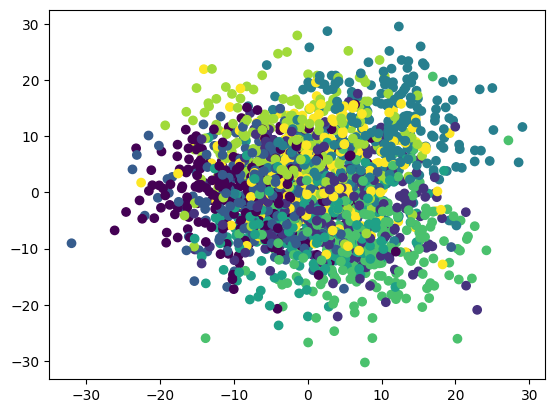

In [3]:
plt.scatter(X[:,0],X[:,1],c=y)

### Encoding your Categorical Target

Use the 📚 [**to_categorical()**](https://www.tensorflow.org/api_docs/python/tf/keras/utils/to_categorical) function to convert `y` to `y_cat`, which is the categorical representation of `y` with **One-Hot encoded** columns.

In [4]:
y_cat = to_categorical(y)

## (1) Cross-Validation in Deep Learning

👩🏻‍🏫 In a previous challenge, we split the dataset into a training set and a testing set at the beginning of the notebook. Then, we started to build different models which were trained on the training set and evaluated on the testing set.

So, at the end of the day, we used the testing set every time we evaluated our models and different hyperparameters. This is normal: we always train on the training set and we evaluate on the testing set.

However, we selected our "best model" based on the score of each model. In other words, we _used_ the test set to select our best model, which means there was ❗️ `data leakage` ❗️

🤔 **what should we do?**

- A first good practice is to avoid using `random_state` or any deterministic separation between your training and testing sets. In that case, your testing set will change every time you re-run your notebook. This is far from being sufficient, though
- To compare models properly, you have to run a cross-validation, a 10-fold split, for instance

🧐 If you look at [sklearn.model_selection.cross_validate](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html), this Cross -Validation tool is designed for Machine Learning algorithms implemented in Scikit Learn, whereas we have been creating and using Neural Networks from Tensorflow/Keras.

🔥 Let's discover how to **Cross-validate a Neural Network**.

### Designing a Neural Network

First, write a function that generates a Neural Network with 3 layers:

<u>Architecture</u>
- an **input layer** with 25 neurons, the `relu` activation function and the appropriate `input_dim`
- a **hidden layer** with 10 neurons and the `relu` activation function.
- a **predictive layer** that is suited to the problem at hand (*multiclass classification*)

<u>Compilation</u>

The function should include a compilation method with:
- the *categorical_crossentropy* loss
- the *Adam* optimizer 
- the *accuracy* metric

In [17]:
def initialize_model():
    model = models.Sequential()
    model.add(layers.Dense(25, activation='relu', input_dim=10))
    model.add(layers.Dense(10, activation='relu'))
    model.add(layers.Dense(8, activation='softmax'))
    
    model.compile(optimizer='adam',
    loss='categorical_crossentropy', 
    metrics = 'accuracy')
    
    return model

### Cross-Validating the Neural Net

🧑🏻‍💻 Write a _loop_ using the [K-Fold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html) function from Scikit-Learn.

* ✂️ Choose 10 splits to fit your model on the training data
* 🧪 Evaluate your model on the testing data, and store the results of the evaluation into a `results` variable.

_Hints_:
* ⚖️ Do not forget to standardize your training data before fitting the NN
* 👌 150 epochs should be sufficient for a first approximation
* 🤝 As this is your first Deep Learning Cross-Validation, you are guided; just uncomment the following cell and follow the steps
* ⏳ Notice that we added `%% time` at the beginning of this Jupyter Notebook cell to display its running time, and we encourage you to do so whenever you run expensive computations

In [10]:
X

array([[  4.89288512,   7.08677321,  21.05545768, ...,  19.7441001 ,
         -8.93283471,  14.42818621],
       [  3.17961962,  -1.58178445,   0.07513401, ...,   3.05763947,
          7.2070339 ,   5.31353846],
       [ -5.21488471,  -5.27274761,   4.67600162, ...,  16.7358965 ,
         -5.44165475,  -6.2014499 ],
       ...,
       [ -5.53457074,  22.67504107,   7.876074  , ...,  12.01792384,
        -14.28710269,  10.06387513],
       [  0.26202661,  12.23103144, -17.57885724, ...,  -4.44616971,
         -9.3486339 , -18.23975558],
       [ -0.17532791,   8.41206215,  10.01095841, ..., -14.67941956,
          8.52341995, -12.78346935]])

In [18]:
import pandas as pd

In [32]:
%%time

kf = KFold(n_splits=10)
kf.get_n_splits(X)

results = []
results2 = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y_cat[train_index], y_cat[test_index]
#     # Split the data into train and test
    ss = StandardScaler()
    ss.fit(X_train,y_train)###
    X_train_scaled = ss.transform(X_train)
    X_test_scaled = ss.transform(X_test)
#     # Scaling your data
    model = initialize_model()

#     # Initialize the model
    model.fit(X_train_scaled, 
                        y_train,
                        validation_data = (X_test_scaled, y_test), 
                        epochs = 150,
                        batch_size = 16,
                        verbose=0)

#     # Fit the model on the train data
    results.append(pd.DataFrame({
                'rmsle_final_epoch': [model.evaluate(X_test_scaled, y_test)]}))
    results2.append(model.evaluate(X_test_scaled, y_test))

#     # Evaluate the model on the test data
final_results = pd.concat(results, axis = 0)
final_results.index = np.arange(0, len(results))

7/7 [==============================] - 0s 2ms/step - loss: 0.6253 - accuracy: 0.7650
CPU times: user 3min 37s, sys: 1min 25s, total: 5min 3s
Wall time: 3min 22s


In [30]:
final_results

,rmsle_final_epoch
0,"[0.6553669571876526, 0.7799999713897705]"
1,"[0.8473698496818542, 0.7400000095367432]"
2,"[0.8621810078620911, 0.7200000286102295]"
3,"[0.8245357275009155, 0.7350000143051147]"
4,"[0.7520056366920471, 0.7250000238418579]"
5,"[0.6526947617530823, 0.7900000214576721]"
6,"[0.7813385128974915, 0.7799999713897705]"
7,"[1.0982253551483154, 0.6299999952316284]"
8,"[0.7265061140060425, 0.7649999856948853]"
9,"[0.6931228041648865, 0.7599999904632568]"


In [14]:
for train_index, test_index in kf.split(X):
    print(train_index)
    #print(test_index)

[ 200  201  202 ... 1997 1998 1999]
[   0    1    2 ... 1997 1998 1999]
[   0    1    2 ... 1997 1998 1999]
[   0    1    2 ... 1997 1998 1999]
[   0    1    2 ... 1997 1998 1999]
[   0    1    2 ... 1997 1998 1999]
[   0    1    2 ... 1997 1998 1999]
[   0    1    2 ... 1997 1998 1999]
[   0    1    2 ... 1997 1998 1999]
[   0    1    2 ... 1797 1798 1799]


In [31]:
for train_index, test_index in kf.split(X):
    #print(train_index)
    print(test_index)

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199]
[200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217
 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235
 236 237 238 239 240 241 242 243 244 245 

### Performance of the Cross-Validated Network

Print the average accuracy of these 10 folds and the standard deviation of these 10 accuracy values.

In [33]:
accuracy = [_[1] for _ in results2]

print(f'New mean accuracy: {np.mean(accuracy)*100:.2f}% (±{np.std(accuracy)*100:.2f})')

New mean accuracy: 74.20% (±4.14)


### Remarks About the Computational Time

- 🤯 You probably encountered one of the main drawbacks of using proper cross-validation for a Neural Network: **it takes a lot of time**! Therefore, for the rest of the Deep-Learning module, we will do **only one fold**
- 👮🏻‍♀️ Remember that this is not entirely correct and, for real-life applications and problems, you are encouraged to use a proper cross-validation technique
- 💼 In general, people split only once, as you did. Once they get to the end of their optimization, they launch a real cross-validation run at 6 PM, go home and get the final results on the next day

### Holdout Method

For the rest of the exercise (and of the Deep Learning module), split the dataset into a training set and a testing set with a 70/30% training-to-test data ratio.

Make sure to also scale the data after splitting!

In [34]:
from sklearn.model_selection import train_test_split

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y_cat, test_size=0.3)

In [41]:
# Scale the data
SScaler = StandardScaler()
SScaler.fit(X_train)

X_train_scaled = SScaler.transform(X_train)
X_test_scaled = SScaler.transform(X_test)

## (2) How to Prevent a Neural Network from Overfitting?

### (2.1) Early Stopping

🚦 **Stop the learning process before overfitting**

#### Illustrating How a Neural Network Easily Overfits

First things first, let's show that if we train the model for too long (= for too many epochs) it will overfit the training data and will not be good at predicting the testing data.

**How can we do it without using the testing data, which is strictly forbidden?**

You can use a fraction of the <font color=blue>training set</font> as a <font color=green>validation set</font>.

<img src="https://wagon-public-datasets.s3.amazonaws.com/data-science-images/lectures/deep-learning/02/validation_set.png" width=450>

With Keras, you don't have to re-use the `train_test_split` method from Scikit-Learn. Instead, you have two options:

- `validation_split = 0.2` (for example)
    - The model will take the last 20% of the observations in the training set and use this group as the validation holdout set
    - If you want a random `train_val_split` within the training set, you can also add the argument `shuffle = True` in `model.fit()`
- `validation_data = (X_val, y_val)` if you have access to a dataset that you want to use as the validation holdout set.

👉 Let's go with the first option and set `epochs = 500`. 

👉 Store the performances of the model in a `history` variable.

In [44]:
%%time
history = model.fit(X_train_scaled, y_train,
          validation_split=0.2, # /!\ LAST 20% of train indexes are used as validation
          batch_size=16,
          epochs=500,
                   shuffle=True)

Epoch 1/500
70/70 [==============================] - 0s 2ms/step - loss: 1.4384 - accuracy: 0.5179 - val_loss: 1.0113 - val_accuracy: 0.6321
Epoch 2/500
70/70 [==============================] - 0s 2ms/step - loss: 0.7750 - accuracy: 0.7509 - val_loss: 0.8648 - val_accuracy: 0.6643
Epoch 3/500
70/70 [==============================] - 0s 2ms/step - loss: 0.6750 - accuracy: 0.7804 - val_loss: 0.8124 - val_accuracy: 0.7143
Epoch 4/500
70/70 [==============================] - 0s 2ms/step - loss: 0.6259 - accuracy: 0.7982 - val_loss: 0.7827 - val_accuracy: 0.7143
Epoch 5/500
70/70 [==============================] - 0s 2ms/step - loss: 0.5900 - accuracy: 0.8027 - val_loss: 0.7614 - val_accuracy: 0.7214
Epoch 6/500
70/70 [==============================] - 0s 2ms/step - loss: 0.5639 - accuracy: 0.8196 - val_loss: 0.7467 - val_accuracy: 0.7286
Epoch 7/500
70/70 [==============================] - 0s 2ms/step - loss: 0.5440 - accuracy: 0.8223 - val_loss: 0.7351 - val_accuracy: 0.7250
Epoch 8/500
7

Epoch 59/500
70/70 [==============================] - 0s 2ms/step - loss: 0.3487 - accuracy: 0.8786 - val_loss: 0.7890 - val_accuracy: 0.7357
Epoch 60/500
70/70 [==============================] - 0s 1ms/step - loss: 0.3459 - accuracy: 0.8759 - val_loss: 0.7867 - val_accuracy: 0.7393
Epoch 61/500
70/70 [==============================] - 0s 2ms/step - loss: 0.3451 - accuracy: 0.8786 - val_loss: 0.7908 - val_accuracy: 0.7393
Epoch 62/500
70/70 [==============================] - 0s 2ms/step - loss: 0.3439 - accuracy: 0.8813 - val_loss: 0.7958 - val_accuracy: 0.7357
Epoch 63/500
70/70 [==============================] - 0s 2ms/step - loss: 0.3445 - accuracy: 0.8768 - val_loss: 0.8001 - val_accuracy: 0.7357
Epoch 64/500
70/70 [==============================] - 0s 2ms/step - loss: 0.3409 - accuracy: 0.8786 - val_loss: 0.8055 - val_accuracy: 0.7393
Epoch 65/500
70/70 [==============================] - 0s 2ms/step - loss: 0.3395 - accuracy: 0.8857 - val_loss: 0.7955 - val_accuracy: 0.7357
Epoch 

70/70 [==============================] - 0s 2ms/step - loss: 0.2855 - accuracy: 0.9018 - val_loss: 0.9143 - val_accuracy: 0.7429
Epoch 117/500
70/70 [==============================] - 0s 2ms/step - loss: 0.2850 - accuracy: 0.9027 - val_loss: 0.9100 - val_accuracy: 0.7393
Epoch 118/500
70/70 [==============================] - 0s 2ms/step - loss: 0.2829 - accuracy: 0.9009 - val_loss: 0.9084 - val_accuracy: 0.7393
Epoch 119/500
70/70 [==============================] - 0s 2ms/step - loss: 0.2839 - accuracy: 0.9036 - val_loss: 0.9164 - val_accuracy: 0.7357
Epoch 120/500
70/70 [==============================] - 0s 2ms/step - loss: 0.2825 - accuracy: 0.9062 - val_loss: 0.9195 - val_accuracy: 0.7429
Epoch 121/500
70/70 [==============================] - 0s 2ms/step - loss: 0.2833 - accuracy: 0.8991 - val_loss: 0.9165 - val_accuracy: 0.7357
Epoch 122/500
70/70 [==============================] - 0s 2ms/step - loss: 0.2824 - accuracy: 0.9089 - val_loss: 0.9117 - val_accuracy: 0.7393
Epoch 123/500

70/70 [==============================] - 0s 2ms/step - loss: 0.2482 - accuracy: 0.9170 - val_loss: 1.0300 - val_accuracy: 0.7464
Epoch 174/500
70/70 [==============================] - 0s 2ms/step - loss: 0.2465 - accuracy: 0.9170 - val_loss: 1.0317 - val_accuracy: 0.7393
Epoch 175/500
70/70 [==============================] - 0s 1ms/step - loss: 0.2467 - accuracy: 0.9214 - val_loss: 1.0395 - val_accuracy: 0.7464
Epoch 176/500
70/70 [==============================] - 0s 2ms/step - loss: 0.2457 - accuracy: 0.9170 - val_loss: 1.0475 - val_accuracy: 0.7393
Epoch 177/500
70/70 [==============================] - 0s 2ms/step - loss: 0.2456 - accuracy: 0.9170 - val_loss: 1.0525 - val_accuracy: 0.7357
Epoch 178/500
70/70 [==============================] - 0s 2ms/step - loss: 0.2453 - accuracy: 0.9250 - val_loss: 1.0502 - val_accuracy: 0.7393
Epoch 179/500
70/70 [==============================] - 0s 2ms/step - loss: 0.2452 - accuracy: 0.9187 - val_loss: 1.0417 - val_accuracy: 0.7500
Epoch 180/500

70/70 [==============================] - 0s 2ms/step - loss: 0.2208 - accuracy: 0.9312 - val_loss: 1.1820 - val_accuracy: 0.7179
Epoch 231/500
70/70 [==============================] - 0s 2ms/step - loss: 0.2208 - accuracy: 0.9312 - val_loss: 1.1829 - val_accuracy: 0.7143
Epoch 232/500
70/70 [==============================] - 0s 2ms/step - loss: 0.2172 - accuracy: 0.9250 - val_loss: 1.1811 - val_accuracy: 0.7214
Epoch 233/500
70/70 [==============================] - 0s 2ms/step - loss: 0.2187 - accuracy: 0.9330 - val_loss: 1.1833 - val_accuracy: 0.7036
Epoch 234/500
70/70 [==============================] - 0s 2ms/step - loss: 0.2160 - accuracy: 0.9321 - val_loss: 1.1952 - val_accuracy: 0.7071
Epoch 235/500
70/70 [==============================] - 0s 1ms/step - loss: 0.2156 - accuracy: 0.9339 - val_loss: 1.2034 - val_accuracy: 0.7000
Epoch 236/500
70/70 [==============================] - 0s 2ms/step - loss: 0.2173 - accuracy: 0.9277 - val_loss: 1.1934 - val_accuracy: 0.7036
Epoch 237/500

70/70 [==============================] - 0s 2ms/step - loss: 0.1945 - accuracy: 0.9339 - val_loss: 1.3273 - val_accuracy: 0.7071
Epoch 288/500
70/70 [==============================] - 0s 2ms/step - loss: 0.1947 - accuracy: 0.9384 - val_loss: 1.3264 - val_accuracy: 0.6964
Epoch 289/500
70/70 [==============================] - 0s 2ms/step - loss: 0.1944 - accuracy: 0.9393 - val_loss: 1.3265 - val_accuracy: 0.7107
Epoch 290/500
70/70 [==============================] - 0s 2ms/step - loss: 0.1958 - accuracy: 0.9384 - val_loss: 1.3383 - val_accuracy: 0.7036
Epoch 291/500
70/70 [==============================] - 0s 2ms/step - loss: 0.1944 - accuracy: 0.9384 - val_loss: 1.3379 - val_accuracy: 0.6929
Epoch 292/500
70/70 [==============================] - 0s 2ms/step - loss: 0.1989 - accuracy: 0.9339 - val_loss: 1.3462 - val_accuracy: 0.6893
Epoch 293/500
70/70 [==============================] - 0s 1ms/step - loss: 0.1923 - accuracy: 0.9420 - val_loss: 1.3394 - val_accuracy: 0.7036
Epoch 294/500

70/70 [==============================] - 0s 2ms/step - loss: 0.1780 - accuracy: 0.9446 - val_loss: 1.4517 - val_accuracy: 0.7071
Epoch 345/500
70/70 [==============================] - 0s 1ms/step - loss: 0.1771 - accuracy: 0.9438 - val_loss: 1.4646 - val_accuracy: 0.6964
Epoch 346/500
70/70 [==============================] - 0s 2ms/step - loss: 0.1757 - accuracy: 0.9473 - val_loss: 1.4620 - val_accuracy: 0.7000
Epoch 347/500
70/70 [==============================] - 0s 2ms/step - loss: 0.1745 - accuracy: 0.9438 - val_loss: 1.4597 - val_accuracy: 0.6964
Epoch 348/500
70/70 [==============================] - 0s 2ms/step - loss: 0.1759 - accuracy: 0.9438 - val_loss: 1.4653 - val_accuracy: 0.7071
Epoch 349/500
70/70 [==============================] - 0s 2ms/step - loss: 0.1779 - accuracy: 0.9446 - val_loss: 1.4643 - val_accuracy: 0.7036
Epoch 350/500
70/70 [==============================] - 0s 2ms/step - loss: 0.1790 - accuracy: 0.9429 - val_loss: 1.4711 - val_accuracy: 0.7036
Epoch 351/500

70/70 [==============================] - 0s 2ms/step - loss: 0.1600 - accuracy: 0.9527 - val_loss: 1.6092 - val_accuracy: 0.6929
Epoch 402/500
70/70 [==============================] - 0s 1ms/step - loss: 0.1597 - accuracy: 0.9518 - val_loss: 1.6206 - val_accuracy: 0.7071
Epoch 403/500
70/70 [==============================] - 0s 2ms/step - loss: 0.1640 - accuracy: 0.9473 - val_loss: 1.6238 - val_accuracy: 0.6964
Epoch 404/500
70/70 [==============================] - 0s 2ms/step - loss: 0.1636 - accuracy: 0.9536 - val_loss: 1.6283 - val_accuracy: 0.6821
Epoch 405/500
70/70 [==============================] - 0s 2ms/step - loss: 0.1597 - accuracy: 0.9518 - val_loss: 1.6110 - val_accuracy: 0.6857
Epoch 406/500
70/70 [==============================] - 0s 2ms/step - loss: 0.1606 - accuracy: 0.9536 - val_loss: 1.6127 - val_accuracy: 0.7000
Epoch 407/500
70/70 [==============================] - 0s 2ms/step - loss: 0.1583 - accuracy: 0.9500 - val_loss: 1.6149 - val_accuracy: 0.6929
Epoch 408/500

70/70 [==============================] - 0s 2ms/step - loss: 0.1488 - accuracy: 0.9563 - val_loss: 1.7447 - val_accuracy: 0.6929
Epoch 459/500
70/70 [==============================] - 0s 1ms/step - loss: 0.1476 - accuracy: 0.9580 - val_loss: 1.7595 - val_accuracy: 0.6964
Epoch 460/500
70/70 [==============================] - 0s 2ms/step - loss: 0.1493 - accuracy: 0.9536 - val_loss: 1.7522 - val_accuracy: 0.6929
Epoch 461/500
70/70 [==============================] - 0s 2ms/step - loss: 0.1485 - accuracy: 0.9563 - val_loss: 1.7689 - val_accuracy: 0.6893
Epoch 462/500
70/70 [==============================] - 0s 2ms/step - loss: 0.1477 - accuracy: 0.9545 - val_loss: 1.7731 - val_accuracy: 0.6786
Epoch 463/500
70/70 [==============================] - 0s 2ms/step - loss: 0.1492 - accuracy: 0.9625 - val_loss: 1.7859 - val_accuracy: 0.6893
Epoch 464/500
70/70 [==============================] - 0s 2ms/step - loss: 0.1518 - accuracy: 0.9500 - val_loss: 1.7659 - val_accuracy: 0.6893
Epoch 465/500

#### Your Neural Network's Performance

Evaluate the model on the testing set and print the accuracy.

In [45]:
model.evaluate(X_test_scaled, y_test)

19/19 [==============================] - 0s 935us/step - loss: 2.2982 - accuracy: 0.6600


[2.2981669902801514, 0.6600000262260437]

#### Learnings About Number of Epochs

Plot the history of the model with the `plot_loss_accuracy()` function that we coded for you.

What do you observe? 

In [46]:
def plot_loss_accuracy(history, title=None):
    fig, ax = plt.subplots(1,2, figsize=(20,7))

    # --- LOSS --- 

    ax[0].plot(history.history['loss'])
    ax[0].plot(history.history['val_loss'])

    ax[0].set_title('Model loss')
    ax[0].set_ylabel('Loss')
    ax[0].set_xlabel('Epoch')

    ax[0].set_ylim((0,3))

    ax[0].legend(['Train', 'Test'], loc='best')

    ax[0].grid(axis="x",linewidth=0.5)
    ax[0].grid(axis="y",linewidth=0.5)

    # --- ACCURACY

    ax[1].plot(history.history['accuracy'])
    ax[1].plot(history.history['val_accuracy'])

    ax[1].set_title('Model Accuracy')
    ax[1].set_ylabel('Accuracy')
    ax[1].set_xlabel('Epoch')

    ax[1].legend(['Train', 'Test'], loc='best')

    ax[1].set_ylim((0,1))

    ax[1].grid(axis="x",linewidth=0.5)
    ax[1].grid(axis="y",linewidth=0.5)

    if title:
        fig.suptitle(title)

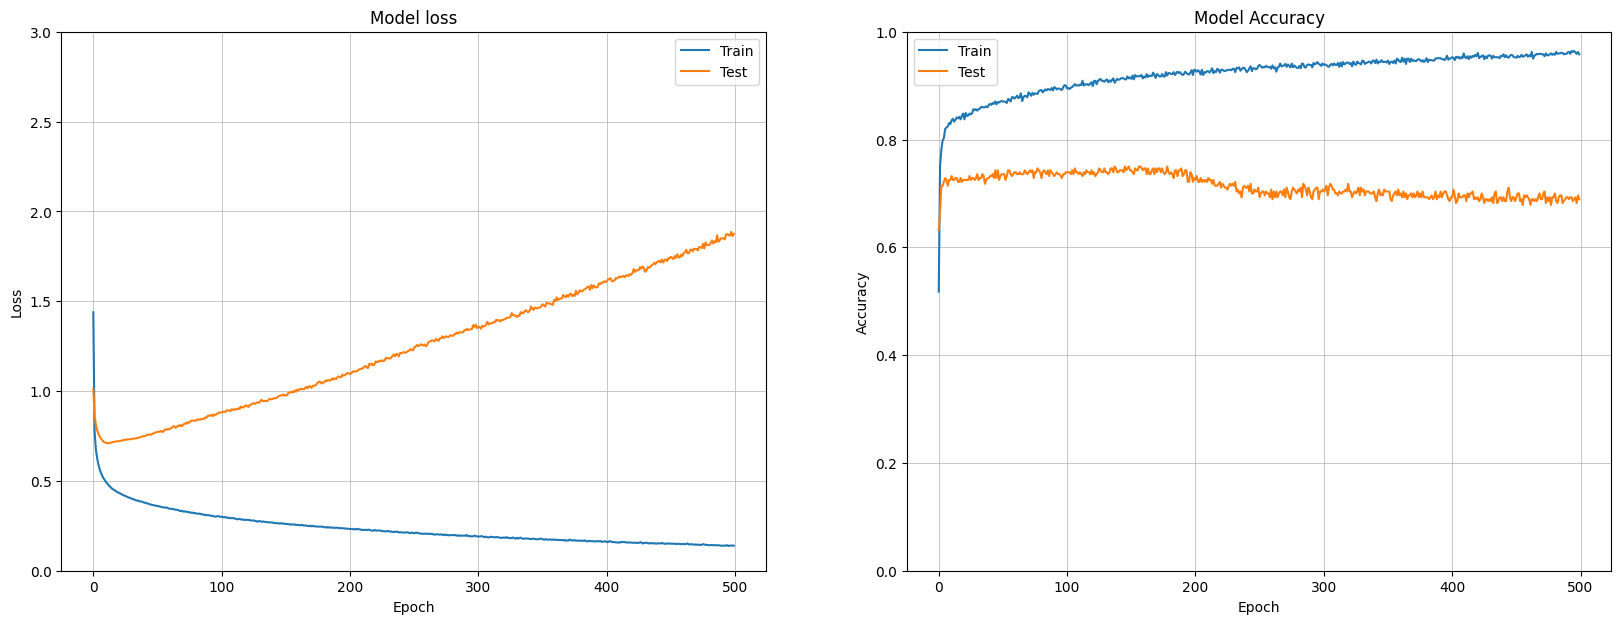

In [47]:
plot_loss_accuracy(history)

👩🏻‍🏫 We clearly see that **the number of epochs we choose has a strong influence on the final results**: 

**INSUFFICIENT NUMBER OF EPOCHS $\implies$ UNDERFITTING**:
- The algorithm is not optimal as its Loss Function has **not converged yet**
- It hasn't learned enough from the training data

**TOO MANY EPOCHS** $\implies$ **OVERFITTING**: 
- Our Neural Network has **learned too much** from the training data, including its noisy information
- the algorithm **does not generalize well** on test data

🚦 Basically, what we want to do is stop the algorithm **when the test loss is minimal** (or when the testing metrics are maximal)

#### Early Stopping

🧑🏻‍🏫 Let's introduce the **Early Stopping** criterion.

The Early Stopping criterion is a way to **automatically stop the training of the algorithm** before reaching the number of epochs that was originally set.

🕵🏻‍♂️ **How does it work?**

The model will pay attention to the **<font color=green>loss of the validation set</font>**. If <font color=green>it</font> starts increasing again 📈 while the <font color=blue>loss of the training set</font> keeps decreasing 📉, it is a good sign that the model is overfitting and the training should be stopped!


<img src="validation_set.png" alt="Validation set" width=450/>

##### Observing the Early Stopping Criterion

Run the following code and plot the history.

In [48]:
%%time

es = EarlyStopping()

model = initialize_model()

# Fit the model on the train data
history = model.fit(
    X_train_scaled,
    y_train,
    validation_split = 0.3,
    epochs = 500,
    batch_size = 16, 
    verbose = 1, 
    callbacks = [es] # This will call the Early Stopping Criterion for each epoch
)

Epoch 1/500
62/62 [==============================] - 0s 3ms/step - loss: 1.9250 - accuracy: 0.2451 - val_loss: 1.8117 - val_accuracy: 0.3349
Epoch 2/500
62/62 [==============================] - 0s 2ms/step - loss: 1.6642 - accuracy: 0.4168 - val_loss: 1.5846 - val_accuracy: 0.5154
CPU times: user 788 ms, sys: 63.7 ms, total: 851 ms
Wall time: 700 ms


In [52]:
history.__dict__

{'validation_data': None,
 'model': <keras.engine.sequential.Sequential at 0x7f4718614070>,
 '_chief_worker_only': None,
 '_supports_tf_logs': False,
 'history': {'loss': [1.9249831438064575, 1.6641870737075806],
  'accuracy': [0.24514810740947723, 0.41675180196762085],
  'val_loss': [1.811730146408081, 1.5846116542816162],
  'val_accuracy': [0.3349168598651886, 0.5154394507408142]},
 'params': {'verbose': 1, 'epochs': 500, 'steps': 62},
 'epoch': [0, 1]}

##### Evaluate the ES Model

_(also look at the historical losses)_

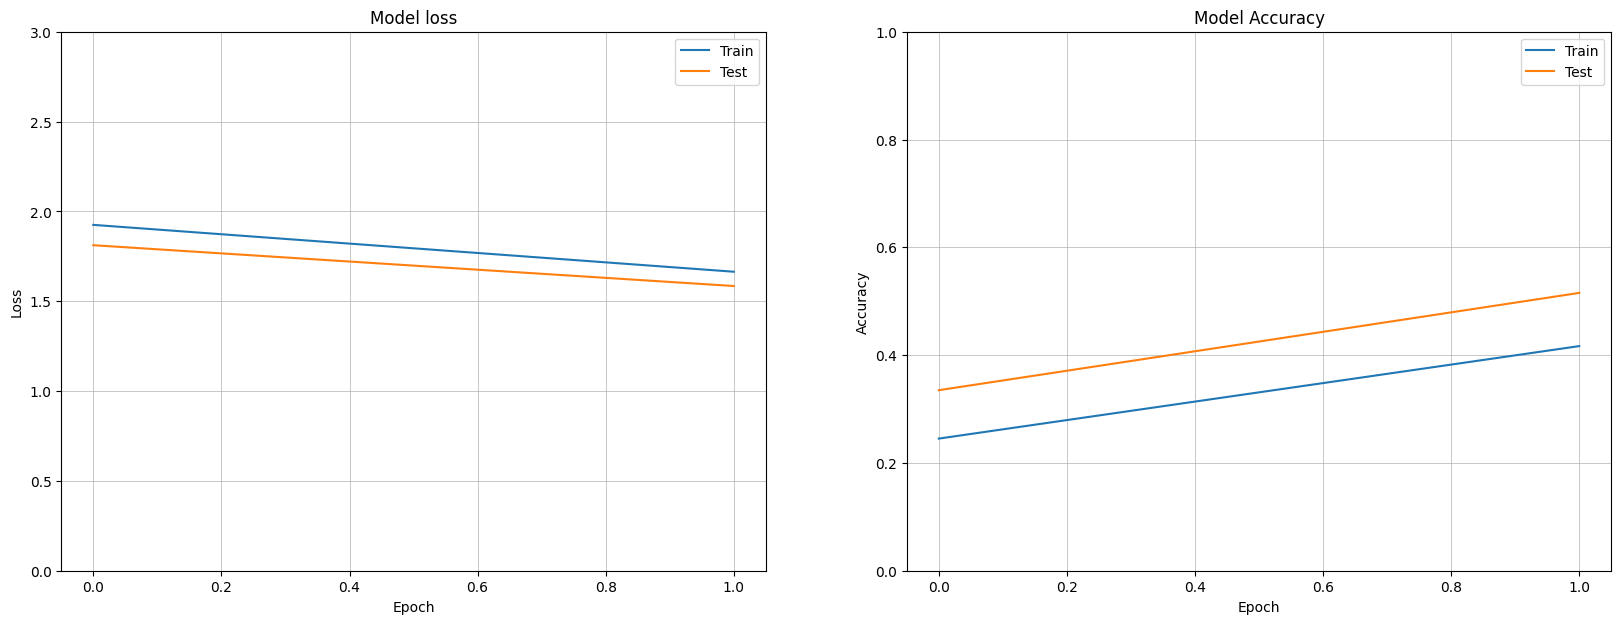

In [49]:
plot_loss_accuracy(history)

❗ **The problem with strict Early Stopping** ❗ 

The problem with this type of approach is that as soon as the loss of the validation set increases, the model stops. However, as a Neural Network's convergence is stochastic, the loss may slightly increase before decreasing again.

✅ The `EarlyStopping` criterion has a `patience` keyword that defines how many **consecutive epochs without any loss decrease** are allowed in the validation set before we stop the training procedure.

Use the `EarlyStopping` criterion with a patience term of 30 epochs, plot the results, and print the accuracy on the testing set

In [53]:
%%time

es = EarlyStopping(patience=30)

model = initialize_model()

# Fit the model on the train data
history = model.fit(
    X_train_scaled,
    y_train,
    validation_split = 0.3,
    epochs = 500,
    batch_size = 16, 
    verbose = 1, 
    callbacks = [es] # This will call the Early Stopping Criterion for each epoch
)

Epoch 1/500
62/62 [==============================] - 0s 4ms/step - loss: 2.0498 - accuracy: 0.1696 - val_loss: 1.9651 - val_accuracy: 0.2518
Epoch 2/500
62/62 [==============================] - 0s 2ms/step - loss: 1.8573 - accuracy: 0.3350 - val_loss: 1.8083 - val_accuracy: 0.3729
Epoch 3/500
62/62 [==============================] - 0s 2ms/step - loss: 1.6663 - accuracy: 0.4351 - val_loss: 1.6159 - val_accuracy: 0.4584
Epoch 4/500
62/62 [==============================] - 0s 2ms/step - loss: 1.4628 - accuracy: 0.5148 - val_loss: 1.4294 - val_accuracy: 0.5059
Epoch 5/500
62/62 [==============================] - 0s 2ms/step - loss: 1.2867 - accuracy: 0.5546 - val_loss: 1.2724 - val_accuracy: 0.5368
Epoch 6/500
62/62 [==============================] - 0s 2ms/step - loss: 1.1237 - accuracy: 0.6313 - val_loss: 1.1127 - val_accuracy: 0.6698
Epoch 7/500
62/62 [==============================] - 0s 3ms/step - loss: 0.9666 - accuracy: 0.7191 - val_loss: 0.9789 - val_accuracy: 0.6817
Epoch 8/500
6

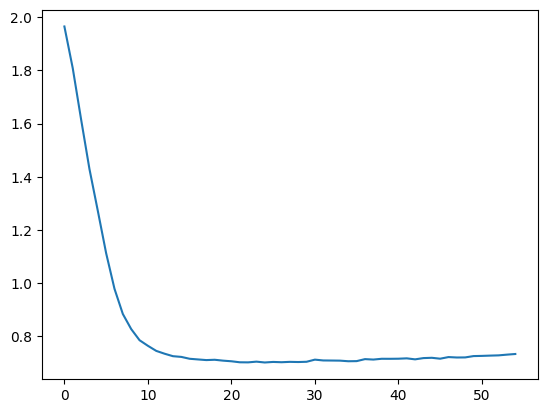

In [69]:
plt.plot(list(range(0,55)),history.__dict__['history']['val_loss'])

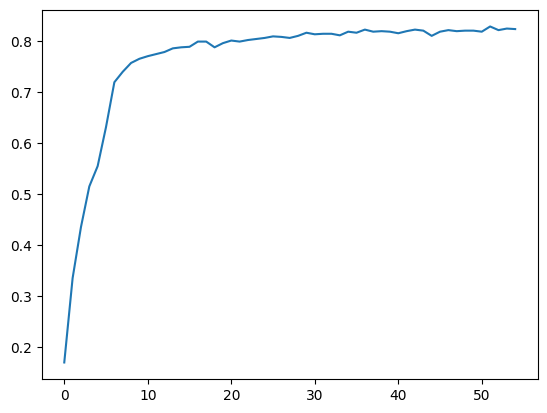

In [62]:
plt.plot(list(range(0,55)),history.__dict__['history']['accuracy'])

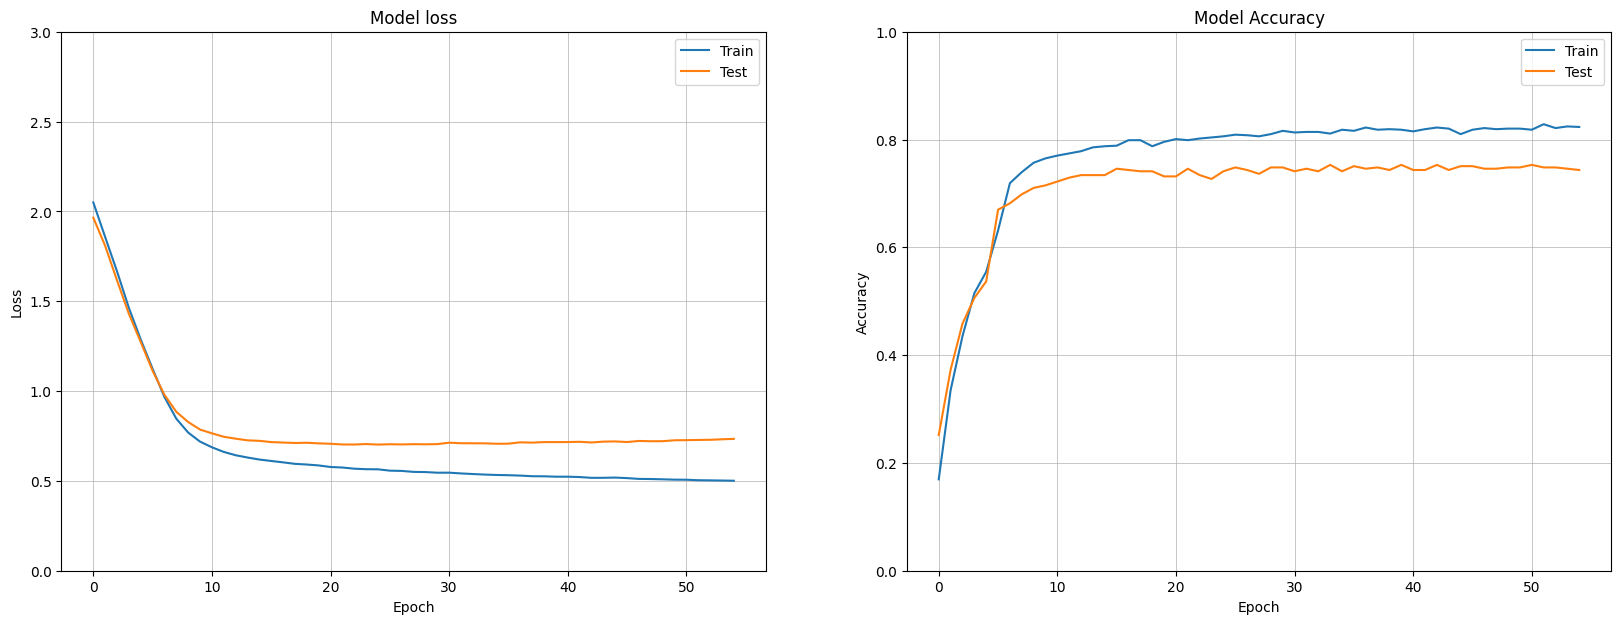

In [54]:
plot_loss_accuracy(history)

🧑🏻‍🏫 **Remarks**


- 📉 The model continues to converge even though its Loss Function had some consecutive loss increases/decreases w.r.t. to the number of epochs
- 🤷🏻‍♂️ The `patience` number to select is highly related to the task at hand, and there is no general rule of thumb
- 🧑🏻‍🏫 If you selected a high patience value for your Early Stopping:
    - 🤞 your Neural Network should theoretically still stop training before the end (not always the case if your number of epochs is too low)
    - ❗️ your validation loss will increase again after reaching a minimum value, but ideally, you want it to be as low as possible; the validation loss potentially reaches a minimum for certain weights at a certain epoch
        - 🤔 How to find these weights?

📚 The `EarlyStopping` criterion enables you to:
- stop the convergence
- restore the best weights of the NN when it had the lowest error level (or the best score) on the validation set, thanks to `restore_best_weights = True` (set to `False` by default)

##### Restoring the Best Weights of a Model

- Run the model with an Early Stopping criterion that will restore the best weights of the Neural Net
- Plot the loss and accuracy 
- Print the accuracy on the testing set

In [70]:
%%time

es = EarlyStopping(patience=10)

model = initialize_model()

# Fit the model on the train data
history = model.fit(
    X_train_scaled,
    y_train,
    validation_split = 0.3,
    epochs = 500,
    batch_size = 16, 
    verbose = 1, 
    callbacks = [es] # This will call the Early Stopping Criterion for each epoch
)

Epoch 1/500
62/62 [==============================] - 0s 3ms/step - loss: 2.0096 - accuracy: 0.1961 - val_loss: 1.9092 - val_accuracy: 0.2613
Epoch 2/500
62/62 [==============================] - 0s 2ms/step - loss: 1.7929 - accuracy: 0.3830 - val_loss: 1.7192 - val_accuracy: 0.4038
Epoch 3/500
62/62 [==============================] - 0s 2ms/step - loss: 1.5783 - accuracy: 0.5077 - val_loss: 1.5095 - val_accuracy: 0.5202
Epoch 4/500
62/62 [==============================] - 0s 2ms/step - loss: 1.3561 - accuracy: 0.6088 - val_loss: 1.3238 - val_accuracy: 0.5582
Epoch 5/500
62/62 [==============================] - 0s 2ms/step - loss: 1.1730 - accuracy: 0.6425 - val_loss: 1.1730 - val_accuracy: 0.5938
Epoch 6/500
62/62 [==============================] - 0s 2ms/step - loss: 1.0346 - accuracy: 0.6813 - val_loss: 1.0516 - val_accuracy: 0.6508
Epoch 7/500
62/62 [==============================] - 0s 2ms/step - loss: 0.9343 - accuracy: 0.6946 - val_loss: 0.9640 - val_accuracy: 0.6627
Epoch 8/500
6

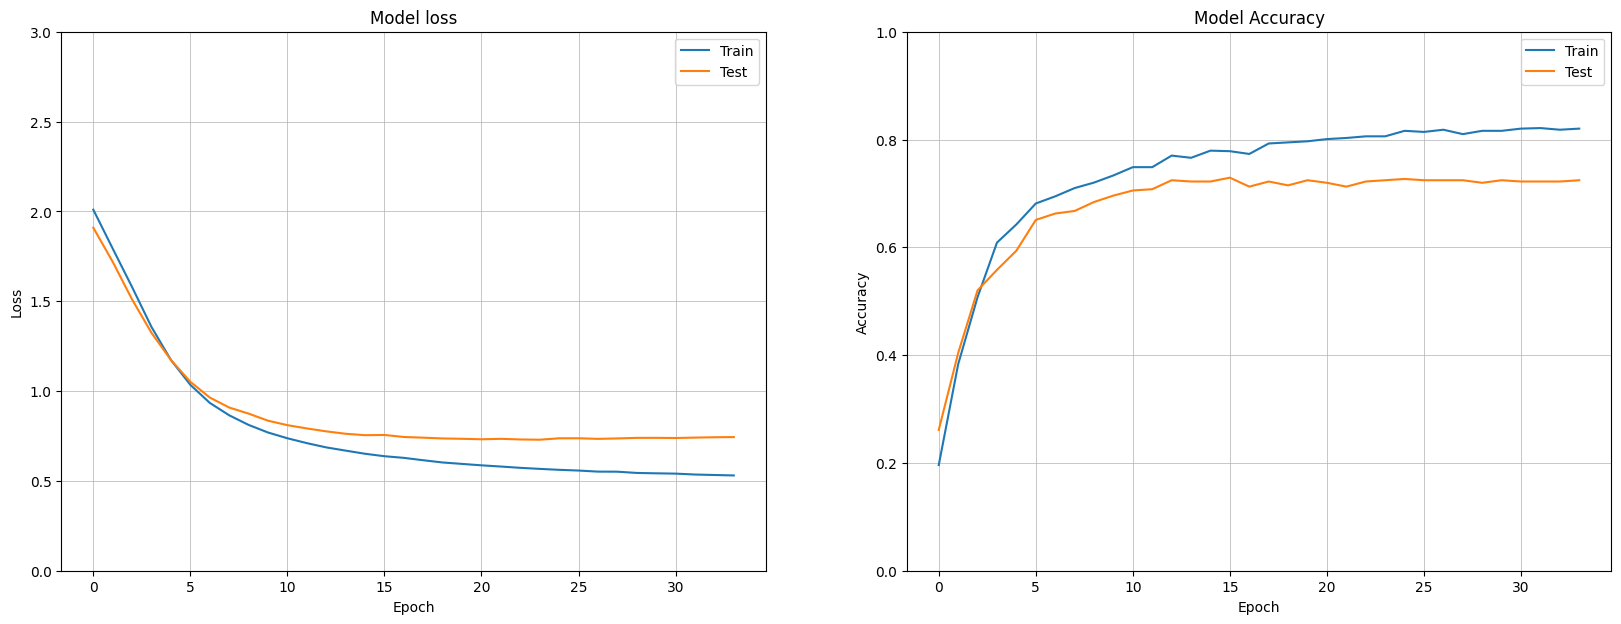

In [71]:
plot_loss_accuracy(history)

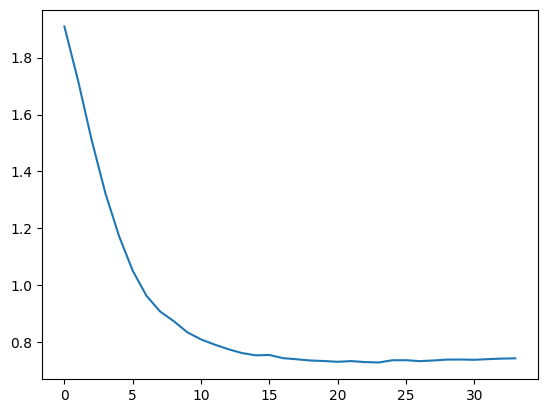

In [73]:
plt.plot(list(range(0,34)),history.__dict__['history']['val_loss'])

🥡 **Takeaways from the Early Stopping criterion:**

- You can look at the 📚 [**Early Stopping documentation**](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping) to play with other parameters
- You no longer need to have a look at the number of epochs as long as the model hits the stopping criterion. So, in the future, you should set a large number of epochs and the Early Stopping criterion will take care of stopping the training procedure before the model overfits! 

### (2.2) Batch Size & Epochs

🕵️‍♀️ Let's investigate the impact of the batch size on training a Neural Network and how we can use it to control how fast the parameters are updated.

#### Playing with the Batch Size

Let's run the previous model with **different batch sizes** (with the Early Stopping criterion included) and plot the results.

👉 Run the following cell

CPU times: user 47.9 s, sys: 20.1 s, total: 1min 8s
Wall time: 45.9 s


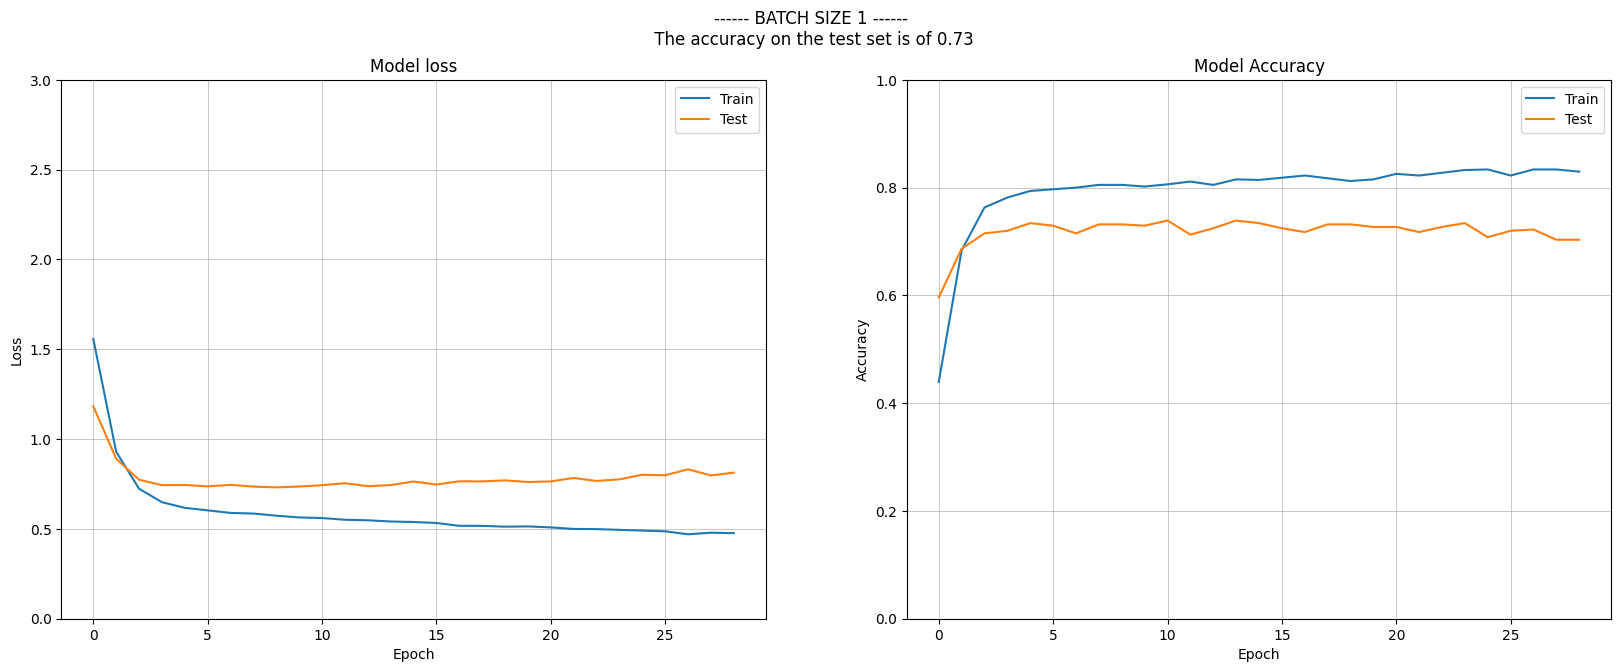

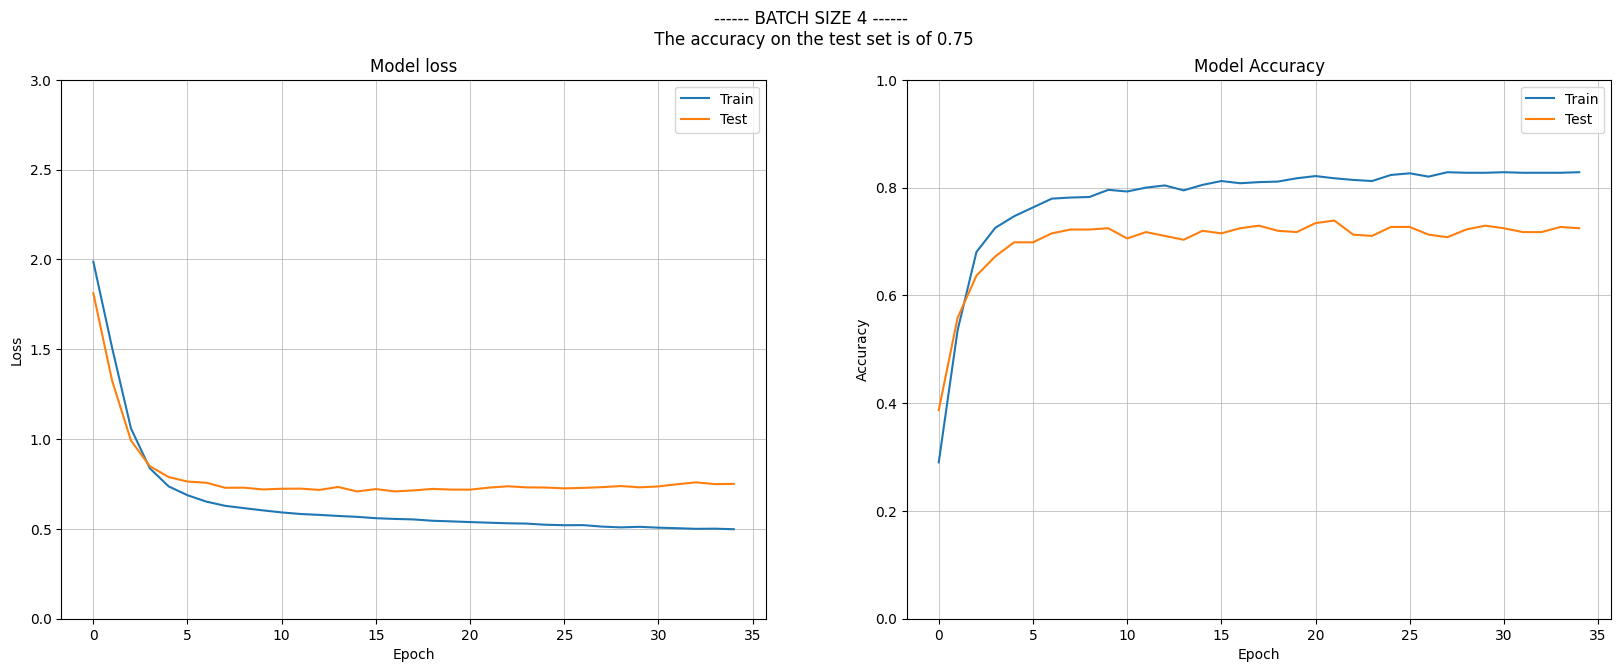

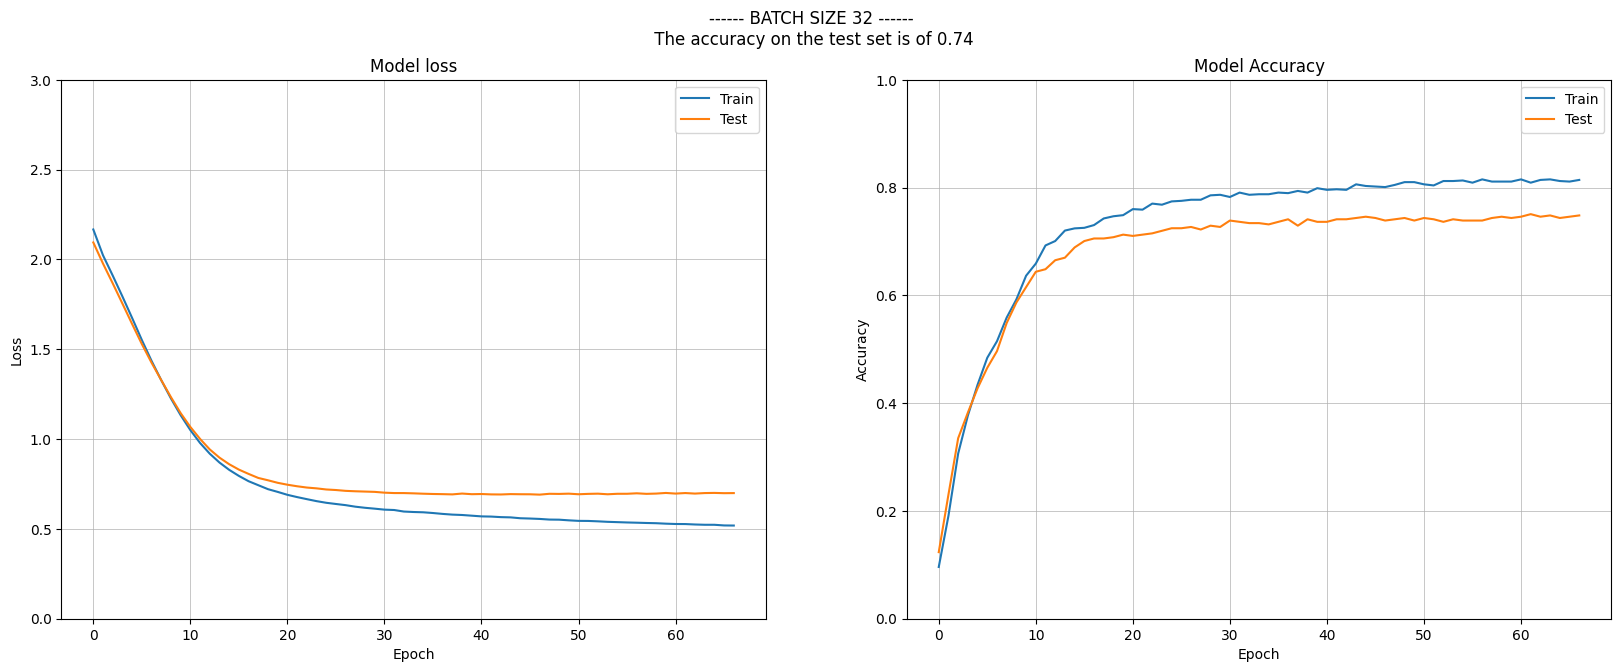

In [74]:
%%time
# RUN THIS CELL
es = EarlyStopping(patience=20, restore_best_weights=True)

for batch_size in [1, 4, 32]:
    
    model = initialize_model()

    history = model.fit(
        X_train_scaled,
        y_train,
        validation_split = 0.3,
        epochs = 500,
        batch_size = batch_size, 
        verbose = 0, 
        callbacks = [es]
    )

    results = model.evaluate(X_test_scaled, y_test, verbose=0)
    plot_loss_accuracy(history, title=f'------ BATCH SIZE {batch_size} ------\n The accuracy on the test set is of {results[1]:.2f}')

#### ❓Question: Impact of the Batch Size on the Convergence of a Neural Network

Look at the oscillations of the accuracy and the loss according to the batch size number. 

Is this coherent with what we saw when playing with the TensorFlow Playground? 

> With the loss functions its largely coherent or reflective of what we saw in the Playground

#### ❓Question: Number of Parameter Updates

How many weight optimizations are done within one epoch (considering the number of observations and the batch size)? Does one epoch have more weight updates with a large or with a small batch size?

> small

#### Explanations

Copy and paste this code into a new cell, run it, and observe.
        
```python
print(f"There are {X_train.shape[0]} rows in the training set")

batch_size = 16
epochs = 2

model = initialize_model()

history = model.fit(
    X_train_scaled,
    y_train,
    validation_split = 0.3,
    epochs = epochs,
    batch_size = batch_size,
    verbose = 1
)
```        


<u><b>Number of parameter updates:</b></u>

- There are 1400 rows in the training set:
    - $ 70 \% \times 1400 = 980 $ rows are used as the training set within the training set
    - $ 30 \% \times 1400 = 420 $ rows are used as the validation set  
- For each epoch, we run a forward/backward propagation $ \large \lceil \frac{980}{batch size} \rceil = \lceil \frac{980}{16}\rceil = 62$ times
- Without the Early Stopping Criterion, we will have _number of_ $ epochs \times 62 = 2 \times 62 = 124 $ iterations overall
        
<u><b>Impact of the batch size:</b></u>

The smaller the batch size 

$ \implies $ The more sub-iterations will be done  
$ \implies $ Parameters will be updated more frequently  
$ \implies $ We may need fewer epochs  

_(but we also don't care too much about the number of epochs if we use an Early Stopping Criterion with a patience term anyway)_    

In [75]:
print(f"There are {X_train.shape[0]} rows in the training set")

batch_size = 16
epochs = 2

model = initialize_model()

history = model.fit(
    X_train_scaled, 
    y_train,
    validation_split = 0.3,
    epochs = epochs,
    batch_size = batch_size, 
    verbose = 1
)

There are 1400 rows in the training set
Epoch 1/2
62/62 [==============================] - 0s 3ms/step - loss: 2.0501 - accuracy: 0.1685 - val_loss: 1.9986 - val_accuracy: 0.2399
Epoch 2/2
62/62 [==============================] - 0s 2ms/step - loss: 1.9191 - accuracy: 0.3197 - val_loss: 1.8580 - val_accuracy: 0.3967


### (2.3) Regularization

❗️**Neural Networks with complex architectures can quickly lead to overfitting** (_too many layers and/or neurons_)❗️

🔥 But since Dense Neural Networks are just activated linear regressions, the weights can be constrained using L1, L2, or L1-L2 penalties!

🚓 So, let's apply some L2 or L1 penalties to these neurons; as in Machine Learning, these penalties are called **`Regularizers`**.

📚 <a href="https://www.tensorflow.org/api_docs/python/tf/keras/regularizers">See `tf.keras.regularizers`</a>

#### Observing Overfitting Before Regularizing

First, let's initialize a model that has too many parameters for the task such that it overfits the training data quickly. To that purpose, let's not use any Early Stopping criterion.

🎁 Let's not waste time re-coding something that you are now used to, just run the following cell and observe what is happening 👇

The accuracy on the testing set is 0.68...
...whereas the accuracy on the training set is 0.85!


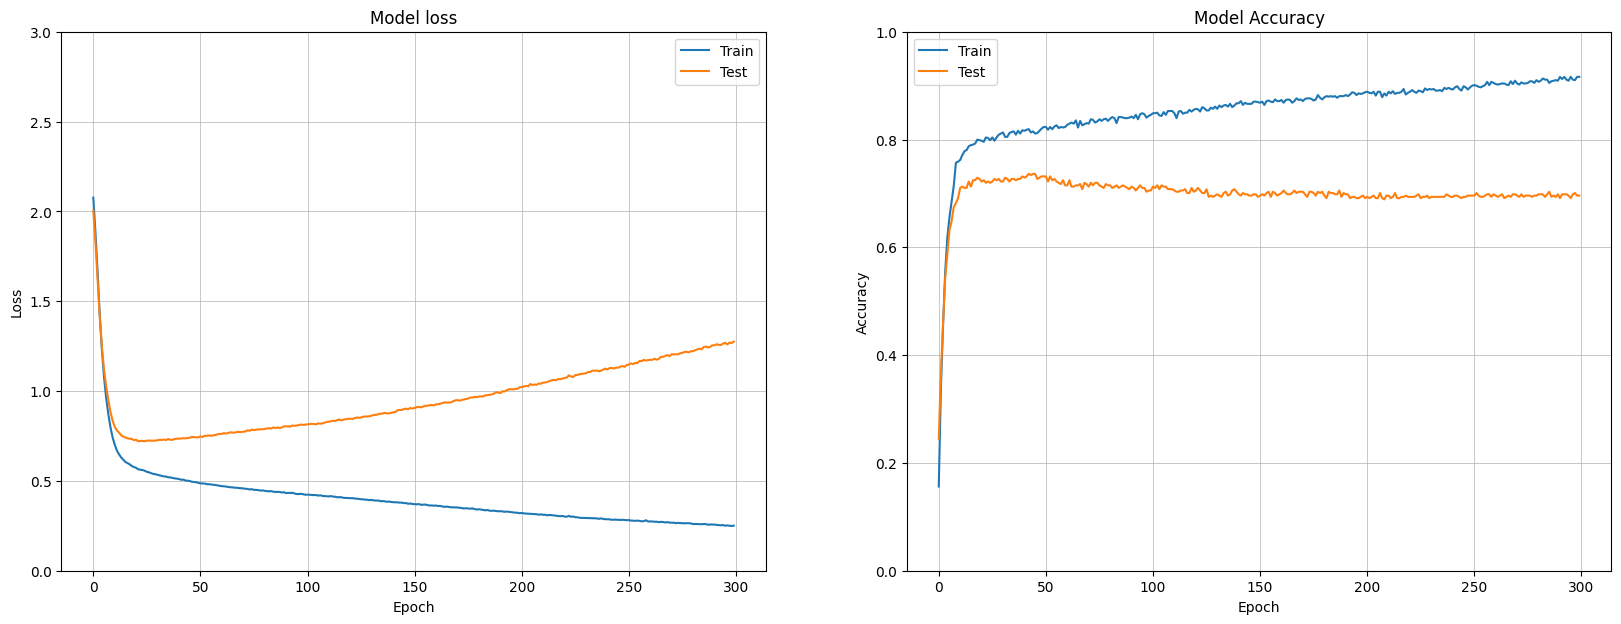

In [76]:
# RUN THIS CELL

# 1. Model Architecture
model = models.Sequential()
model.add(layers.Dense(25, activation='relu', input_dim=10))
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(8, activation='softmax'))

# 2. Model Compilation
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

# 3. Training 
history = model.fit(
    X_train_scaled,
    y_train,
    validation_split = 0.3,
    epochs = 300,           # Notice that we are not using any Early Stopping Criterion
    batch_size = 16, 
    verbose=0
)

# 4. Evaluation
results_train = model.evaluate(X_train_scaled, y_train, verbose = 0)
results_test = model.evaluate(X_test_scaled, y_test, verbose = 0)


# 5. Looking back at what happened during the training phase
print(f'The accuracy on the testing set is {results_test[1]:.2f}...')
print(f'...whereas the accuracy on the training set is {results_train[1]:.2f}!')
plot_loss_accuracy(history)

☝️ In our "over-parameterized network", some neurons became **too specific for the given training data**, preventing the network from generalizing to new data.

😕 This led to some overfitting! 

#### Studying the Impact of Regularization on the Neural Network

Change the previous code to integrate an L2 or L1 regularizer into your Dense Layers.

In [80]:
from tensorflow.keras import regularizers, Sequential, layers

reg_l1 = regularizers.L1(0.01)
reg_l2 = regularizers.L2(0.01)
reg_l1_l2 = regularizers.l1_l2(l1=0.005, l2=0.0005)

The accuracy on the testing set is 0.72...
...whereas the accuracy on the training set is 0.78!


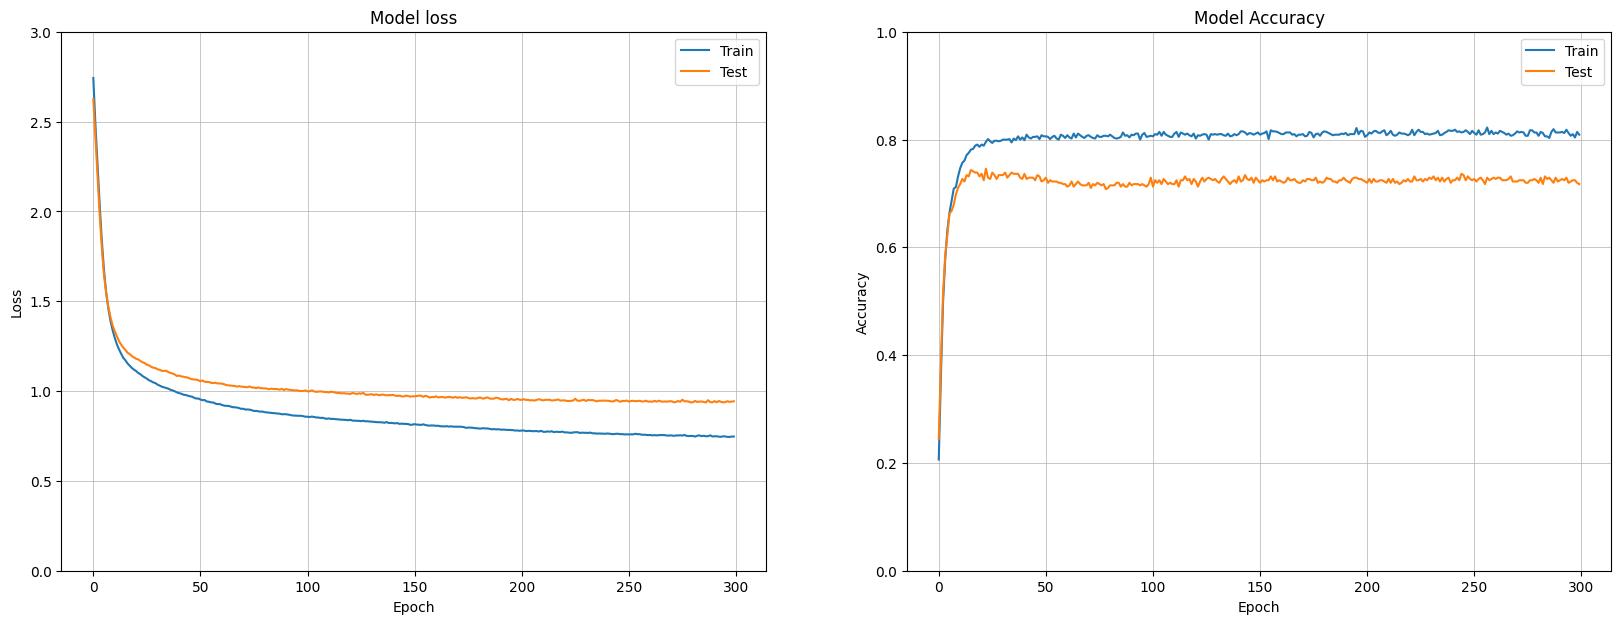

In [86]:
# RUN THIS CELL

# 1. Model Architecture
model = models.Sequential()
model.add(layers.Dense(25, activation='relu', input_dim=10))
model.add(layers.Dense(10, activation='relu',kernel_regularizer=reg_l1))
model.add(layers.Dense(8, activation='softmax',kernel_regularizer=reg_l1))

# 2. Model Compilation
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

# 3. Training 
history = model.fit(
    X_train_scaled,
    y_train,
    validation_split = 0.3,
    epochs = 300,           # Notice that we are not using any Early Stopping Criterion
    batch_size = 16, 
    verbose=0
)

# 4. Evaluation
results_train = model.evaluate(X_train_scaled, y_train, verbose = 0)
results_test = model.evaluate(X_test_scaled, y_test, verbose = 0)


# 5. Looking back at what happened during the training phase
print(f'The accuracy on the testing set is {results_test[1]:.2f}...')
print(f'...whereas the accuracy on the training set is {results_train[1]:.2f}!')
plot_loss_accuracy(history)

### (2.4) Dropout Layers

#### Introduction to Dropout Layers

The role of a Dropout Layer is to randomly cancel the output of some neurons during the training phase, it prevents the network from getting too specific for the input data.

Dropout Layers
- ensure that no neuron can overspecialize in learning a pattern of the dataset because its output is sometimes canceled
- force the information of an input to be spread across multiple neurons instead of only one specific neuron
- are super straightforward to code 👌
  - but what is going on _under the hood_? 👩🏻‍🏫

#### Optional Reading

<details>
    <summary>Click here for further explanations about Dropout Layers</summary>

🤔 Remember what we said about neurons becoming **too specific**? 

**`BEGIN_EXPLANATIONS_ABOUT_DROPOUT_LAYERS`**

---

⚽️  **A Football Analogy:**

Think about a football team. There are 11 players on the pitch, but there are also players on the bench. Why? 
- The coach may want to substitute injured or tired players during the game
- The team may be
    - losing the game and willing to substitute a midfielder with a more **versatile player** who can be more offensive (= **mix of** midfielder/attacker roles) 
    - winning the game and would like to secure the result by replacing a midfielder with a more **versatile player** who can be more defensive (= **mix of** midfielder/defense roles)

💡 Well, in a Neural Net, there is also a risk that a neuron over-specializes in detecting one pattern, where it would be advisable to keep it more versatile.

---

📚 **The goal of [Dropout Layers](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dropout) is to prevent neurons from over-specializing.**

🧑🏻‍🏫 How do Dropout Layers work?

👉 When we apply a **Dropout rate** of 20% to a layer $k$, 20% of the **selected neurons** will have their weights **temporarily set to 0** , which has the following consequences:
1. A neuron computed at layer $k + 1$ considers all the weights as usual, but since some of them were temporarily set to 0, they were “ignored” while creating the neurons of this layer $k + 1$
2. Once a batch of data points has been seen by the Neural Network (**forward propagation**) and 80% of the weights in a layer have been optimized/updated (**backward propagation** with the **Adam** optimizer), the Neural Network moves on to the forward propagation of the next batch, where it will use:
   - 80% of the weights; the ones that were updated
   - 20% of the weights; the ones that were previously ignored and had their values **temporarily** set to 0

Based on these weights, we will go through this Dropout Layer again, which is going to temporarily ignore another 20% of the weights of a given layer. Be careful, the selection of this 20% is random, so the weights that will be ignored this time won't necessarily be the same as before!

👉 Think about the **Dropout rate** as a **sampling with replacement**

👉 By **randomly shutting down** different neurons at different epochs, we force the data points to be **analyzed by different neurons**. At the end of the day, these neurons will become **more versatile** instead of over-specializing!
   
---

**`END_EXPLANATIONS_ABOUT_DROPOUT_LAYERS`**
</details>

#### Studying the Impact of Dropout Layers on the Neural Network

Include some Dropout layers in the architecture of your original model _(don't add regularizers here)_.

What can you observe regarding the convergence of your model? What about its ability to generalize?

The accuracy on the testing set is 0.73...
...whereas the accuracy on the training set is 0.80!


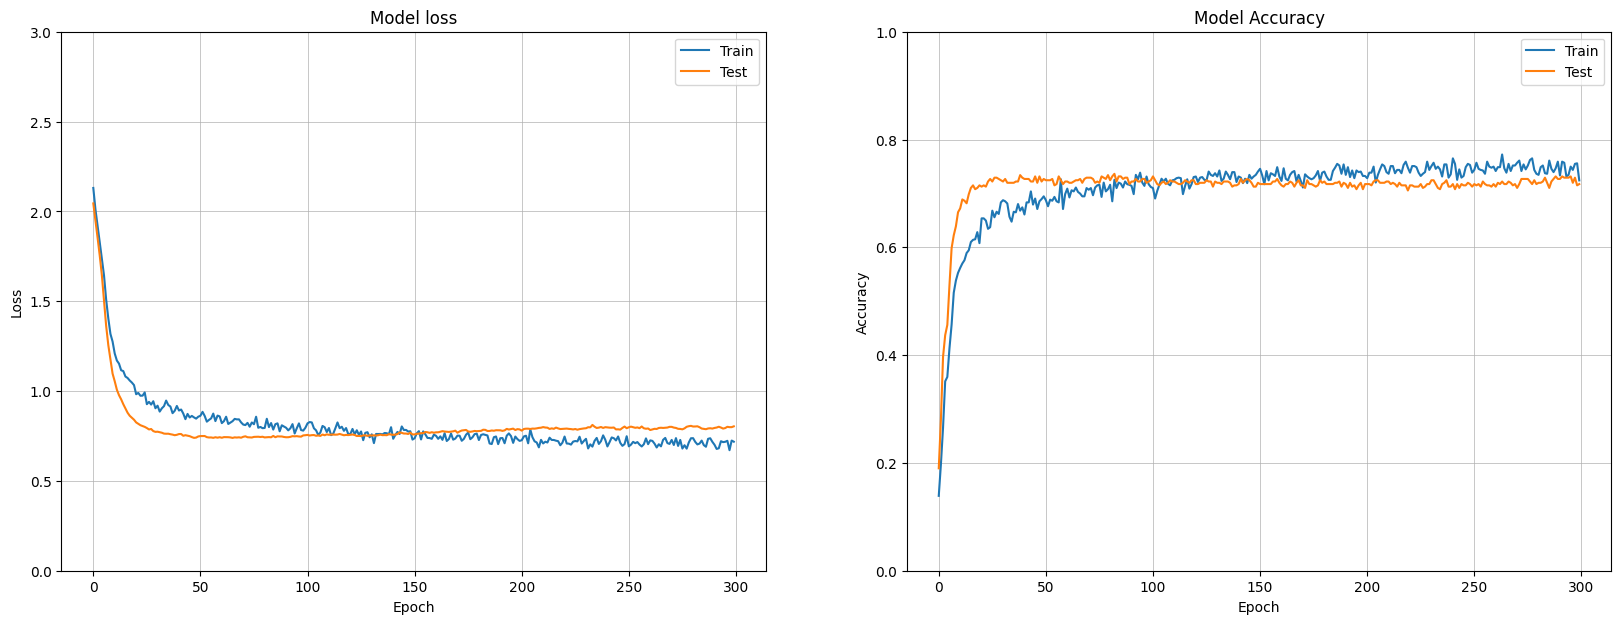

In [87]:
# RUN THIS CELL

# 1. Model Architecture
model = models.Sequential()
model.add(layers.Dense(25, activation='relu', input_dim=10))
model.add(layers.Dropout(rate=0.2))
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dropout(rate=0.2))
model.add(layers.Dense(8, activation='softmax'))

# 2. Model Compilation
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

# 3. Training 
history = model.fit(
    X_train_scaled,
    y_train,
    validation_split = 0.3,
    epochs = 300,           # Notice that we are not using any Early Stopping Criterion
    batch_size = 16, 
    verbose=0
)

# 4. Evaluation
results_train = model.evaluate(X_train_scaled, y_train, verbose = 0)
results_test = model.evaluate(X_test_scaled, y_test, verbose = 0)


# 5. Looking back at what happened during the training phase
print(f'The accuracy on the testing set is {results_test[1]:.2f}...')
print(f'...whereas the accuracy on the training set is {results_train[1]:.2f}!')
plot_loss_accuracy(history)

## (3) Conclusions

- ❗️ If you train a Neural Network too much (too many layers, too many neurons, and/or too many epochs), it will overfit very quickly
- 🥊 To prevent overfitting in Deep Learning, you can use Early Stopping, Regularization, and Dropout Layers
- ❗️ Be careful, if you use these techniques, you might end up on the other spectrum of the performance where your model would underfit the dataset!
- 🆗 You could potentially look at the batch size but we usually use 16 or 32; and as the French Computer Scientist [**Yann Lecun**](https://en.wikipedia.org/wiki/Yann_LeCun) said (Facebook x NYU):

<img src="https://wagon-public-datasets.s3.amazonaws.com/data-science-images/DL/deep_learning_yann_lecun_batch_size.png" alt="batch_size_yann_lecun" width="500">

## 🏁 Congratulations!

💾 Do not forget to `git add/commit/push` your notebook...

🚀 ... and move to the next challenge!